## Sensor properties by screening round

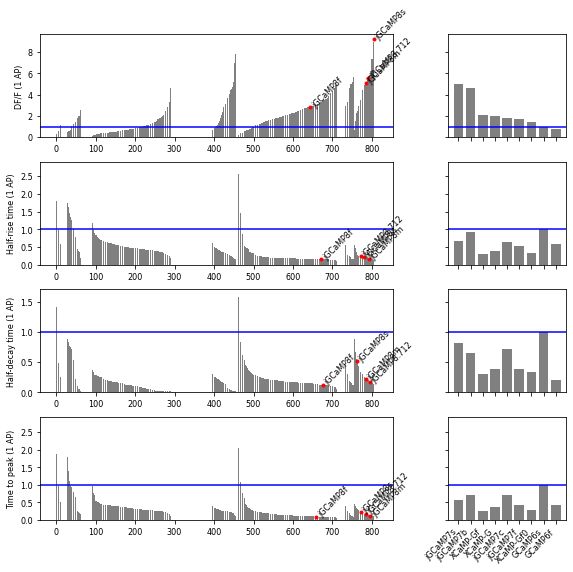

In [3]:
from utils import filter_construct_range
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 8})

cols_to_plot = ['DF/F (1 AP)', 'Half-rise time (1 AP)', 'Half-decay time (1 AP)', 'Time to peak (1 AP)']
jG8_map = {'jGCaMP8f':'500.456', 'jGCaMP8m':'500.686', 'jGCaMP8s':'500.688', 'jGCaMP8.712':'500.712'}
plot_ascending = [True, *[False]*(len(cols_to_plot)-1)]
# load dataset
df = pd.read_csv('outputs/data_filt_public.csv')
df['Construct_allnums'] = df['Construct']
df['Construct_allnums'].replace(jG8_map, inplace=True)

# replace failed constructs with NaN so they can be plotted
df.replace({'Failed segmentation':np.nan, 'No detectable response':np.nan}, inplace=True)
df['DF/F (1 AP)'] = df['DF/F (1 AP)'].astype(float)
# named constructs that are not jG8 series (i.e. XCamp, jG7, jG6)
df_controls = df[df['Construct_allnums'].str.contains('Ca')]
df_controls.set_index('Construct', inplace=True)

# all other constructs (including named jG8)
df_passed_constructs = df[~df['Construct_allnums'].str.contains('Ca')]


n_constructs = len(df_passed_constructs)
n_controls = len(df_controls)
prefixes = ['410','410','500','500','500','500','500']
lows = [1, 33, 2, 306, 375, 647, 672]
highs = [28, 96, 305, 374, 646, 671, 722]

latest_bar_idx = 0

# data for bar plot
bar_data = np.zeros([len(cols_to_plot), n_constructs])

jG8_names = []
jG8_cols = []
jG8_index = []
jG8_val = []
for i,(p,l,h) in enumerate(zip(prefixes, lows, highs)):
    df_round = df_passed_constructs[[filter_construct_range(i, p, l, h) for i in df_passed_constructs['Construct_allnums']]]
    n_constructs_in_round = len(df_round)
    
    for j, col in enumerate(cols_to_plot): # cycle through columns
        df_round_sorted = df_round.sort_values(by=col, ascending=plot_ascending[j]).reset_index()
        df_round_sorted_jG8 = df_round_sorted[df_round_sorted['Construct'].str.contains('jGCaMP8')]
        n_jG8 = len(df_round_sorted_jG8)
        # print(n_jG8)
        if n_jG8 > 0:
            jG8_names.extend(df_round_sorted_jG8['Construct'])
            jG8_cols.extend([col]*n_jG8)
            jG8_index.extend(df_round_sorted_jG8.index + latest_bar_idx)
            jG8_val.extend(df_round_sorted_jG8[col])
        
        bar_data[j,latest_bar_idx + np.arange(n_constructs_in_round)] = df_round_sorted[col]
    
    latest_bar_idx += n_constructs_in_round


df_additionals = pd.DataFrame(data={'name':jG8_names, 'col':jG8_cols, 'index':jG8_index, 'val':jG8_val})

f,axs = plt.subplots(nrows = len(cols_to_plot), ncols=2, figsize=[8,8], sharey='row', gridspec_kw={'width_ratios': [3, 1]})

bar_indices = np.arange(n_constructs)
for i,(b, col_name) in enumerate(zip(bar_data, cols_to_plot)):
    axs[i,0].bar(bar_indices, b, color='gray')
    axs[i,0].set_ylabel(col_name)
    axs[i,0].axhline(y=1, color='blue')
    
    # plot jG8
    df_jG8_plot = df_additionals[df_additionals['col'] == col_name]
    axs[i,0].plot(df_jG8_plot['index'].to_numpy(), df_jG8_plot['val'].to_numpy(), 'r.') #, s=20, color='r', marker='.')
    
    for _, row in df_jG8_plot.iterrows():
        axs[i,0].text(row['index'], row['val'], row['name'], ha='left', rotation=45)

bar_indices_controls = np.arange(n_controls)
for i,col_name in enumerate(cols_to_plot):
    df_controls_col = df_controls[col_name]
    axs[i,1].bar(bar_indices_controls, df_controls_col, color='gray')
    axs[i,1].axhline(y=1, color='blue')
    axs[i,1].set_xticks(bar_indices_controls)
    if i == len(cols_to_plot)-1:
        axs[i,1].set_xticklabels(df_controls_col.index, rotation=45, ha='right')
    else:
        axs[i,1].set_xticklabels([])

plt.tight_layout()